In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

import skeletor as sk

import tqdm

import networkx as nx

from anytree import Node, RenderTree

from pc_skeletor import LBC, SLBC

import open3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


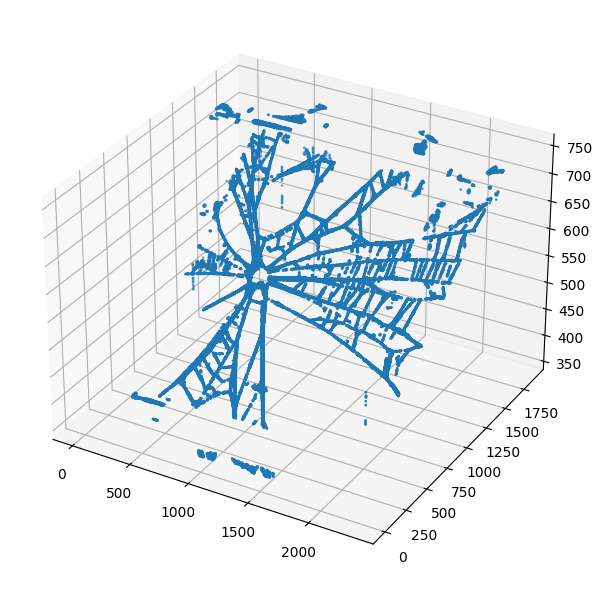

In [2]:
data = '../Data/2d_web_scan.npy'
dsFactor = 1
neighborDistance = 25
np.random.seed(10)

#%matplotlib qt
with open(data, 'rb') as f:
    rawData = np.load(f)
    
order = np.arange(rawData.shape[0])
np.random.shuffle(order)
points = rawData[order][::dsFactor,:]

#plt.scatter(scatterPoints[:,0], scatterPoints[:,2], s=.2)
#plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(points[:,0], points[:,1], points[:,2], s=1)
fig.set_size_inches((6,6))
fig.tight_layout()
#plt.savefig('2d_web_point_cloud.png')
plt.show()

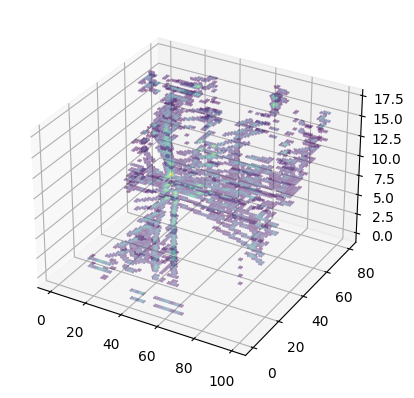

In [12]:
cgField = sk.courseGrainField(points, kernelSize=2)

neighborScatterPoints = np.array(np.where(cgField > .5)).T

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(*neighborScatterPoints.T, s=.2, alpha=.5, c=cgField[np.where(cgField > .5)])
plt.show()

In [14]:
t = 64
octree = sk.skeltre.Octree(points, 20000, 1/t)

[]
No EPair by dim
No EPair by connection dir
No EPair by dim
No EPair by connection dir
No EPair by dim
No EPair by dim
No EPair by dim
No EPair by connection dir
No EPair by dim
No EPair by dim
No EPair by connection dir
No EPair by G(1,1,2) subgraph
No EPair by connection dir
No EPair by dim
No EPair by connection dir
No EPair by connection dir
No EPair by connection dir
No EPair by G(1,1,2) subgraph
No EPair by dim
No EPair by dim
[]
No EPair by dim
No EPair by dim
No EPair by dim
No EPair by dim
No EPair by dim
No EPair by dim
No EPair by dim
No EPair by dim
No EPair by dim
No EPair by dim
No EPair by dim
No EPair by dim
No EPair by dim
No EPair by dim
No EPair by dim
No EPair by dim
No EPair by dim
No EPair by dim
No EPair by dim
No EPair by dim
No EPair by dim
No EPair by dim
No EPair by dim
No EPair by dim
No EPair by dim
No EPair by dim
No EPair by dim
No EPair by dim
No EPair by dim
No EPair by dim
No EPair by dim
No EPair by dim
No EPair by count
No EPair by count
No EPair b

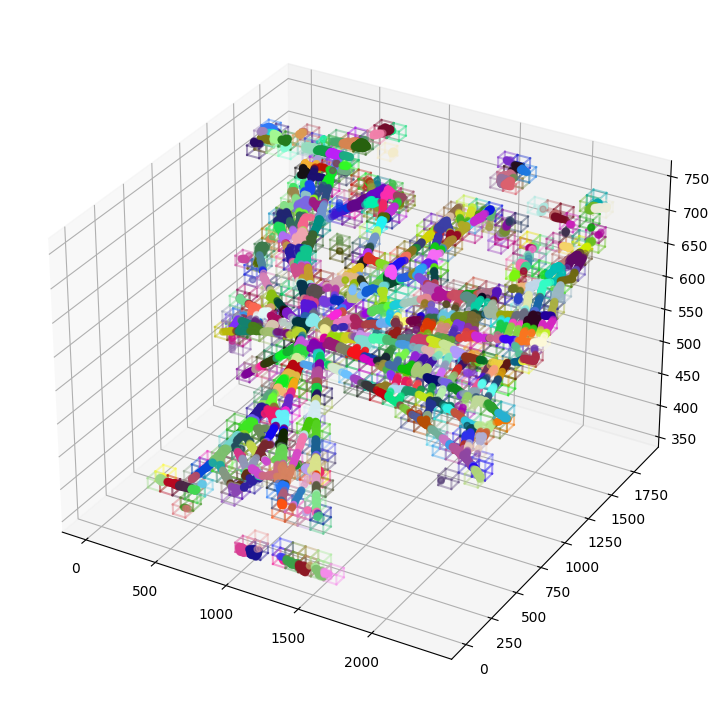

In [9]:
fig = octree.plot()
fig.set_size_inches((10,10))
plt.show()

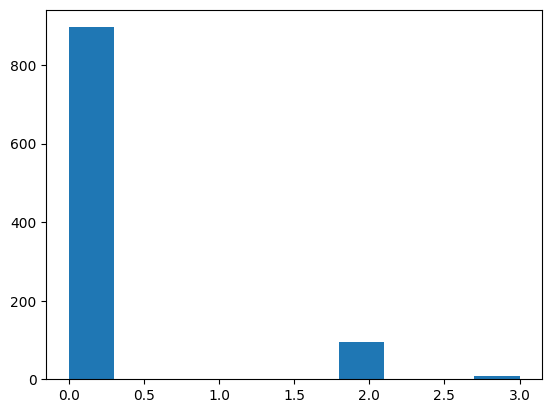

In [4]:
plt.hist(octree.vDimArr.flatten())
plt.show()

In [7]:
%matplotlib inline

for t in [8, 16, 24, 32, 64, 128]:
    octree = sk.ask.Octree(points, 20000, 1/t)

    fig = octree.plotSkeleton(plotBoxes=False)
    fig.set_size_inches((8,8))

    fig.suptitle(f't = {t}')
    fig.tight_layout()
    plt.savefig(f'ask_t{t}.png', bbox_inches='tight')
    plt.show()

KeyError: (0, 1, 0)

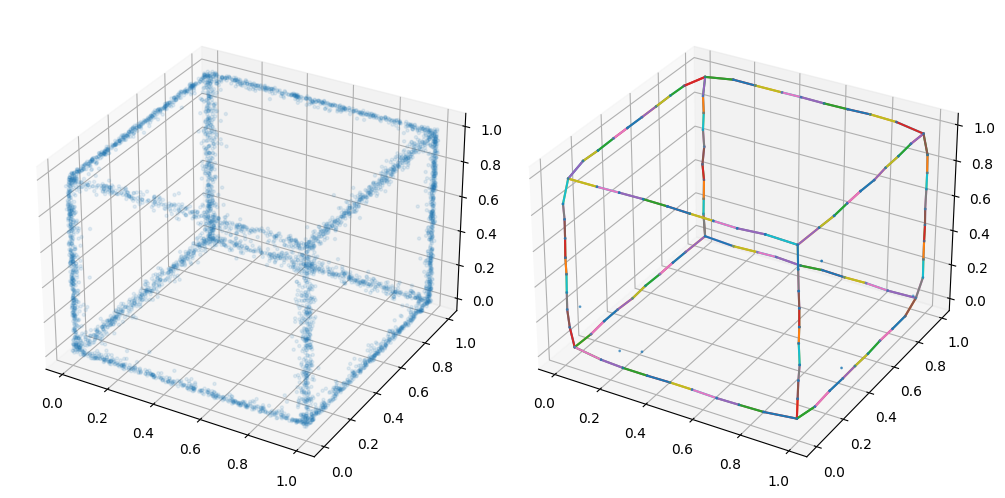

In [6]:
%matplotlib inline
centroids = octree.getCentroids()
adjMat = octree.getAdjMat()

fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')

ax1.scatter(points[:,0], points[:,1], points[:,2], s=5, alpha=.1)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax2.scatter(centroids[:,0], centroids[:,1], centroids[:,2], s=1)

for i in range(len(adjMat)):
    edgeIndices = np.where(adjMat[i] > 0)[0]
    for j in range(len(edgeIndices)):
        ax2.plot(*list(zip(centroids[i], centroids[edgeIndices[j]])))

fig.tight_layout()
#plt.savefig('cube_discrete_skeleton.png')
plt.show()

In [7]:
dominantDirections = []
adjMat = octree.getAdjMat()
centroids = octree.getCentroids()

for i in tqdm.tqdm(range(len(centroids))):
    hist, thetaBins, phiBins = sk.angularHistogramAroundPoint(centroids, i, adjMat, smoothing=21)
    peakDirections = sk.findDominantHistogramDirections(hist, thetaBins, phiBins, normalize=True)

    dominantDirections.append(peakDirections)

 10%|███▏                            | 11/110 [00:00<00:01, 98.49it/s]../skeletor/peak_finding.py:97: RuntimeWarning: invalid value encountered in true_divide
  peakPrevalences /= dataRange
100%|██████████████████████████████| 110/110 [00:01<00:00, 101.85it/s]


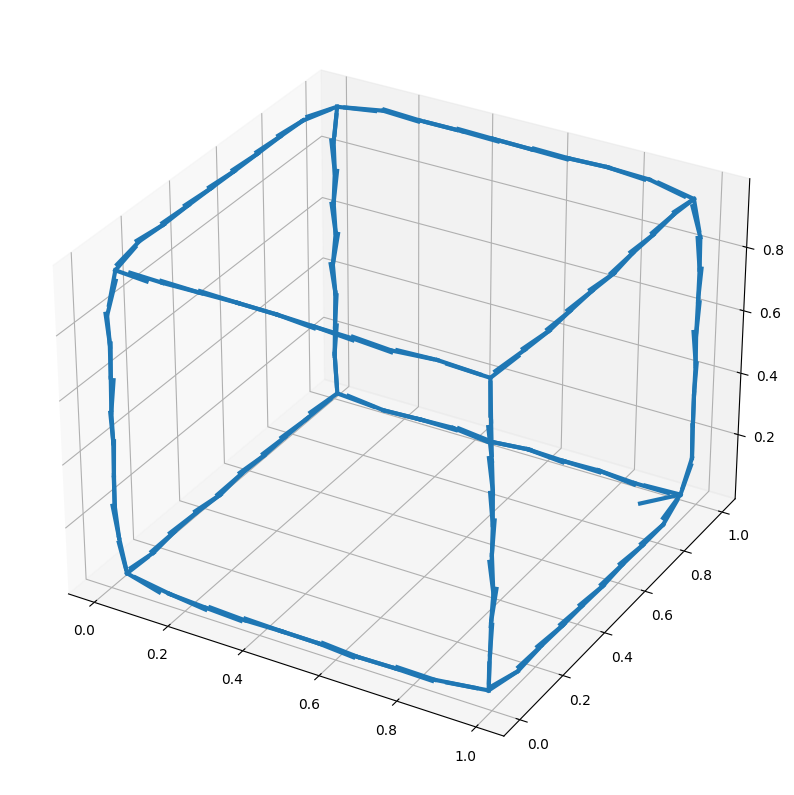

In [8]:
fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(projection='3d')

for i in range(len(centroids)):
    for j in range(len(dominantDirections[i])):
        linePoints = np.array([centroids[i], centroids[i] - .1*dominantDirections[i][j]])
        ax.plot(linePoints[:,0], linePoints[:,1], linePoints[:,2], linewidth=3, c='tab:blue')

plt.show()

In [3]:
pointCloud = open3d.geometry.PointCloud()
pointCloud.points = open3d.utility.Vector3dVector(points)

2023-04-24 08:53:43,996 - PCD #points: 60413
Current volume ratio 0.017897770555838247. Contraction weights 2048.0.2023-04-24 08:55:05,935 - Contraction is Done.
Current volume ratio 0.017897770555838247. Contraction weights 2048.0.

Contraction is Done.



/home/jack/anaconda3/envs/ml/lib/python3.7/site-packages/mistree/mst/branches.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  branch_index.append(np.ndarray.tolist(np.ndarray.flatten(np.array(_twig))))
/home/jack/anaconda3/envs/ml/lib/python3.7/site-packages/mistree/mst/branches.py:139: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  branch_index = [np.ndarray.tolist(np.hstack(np.array(branch_index[i]))) for i in range(0, len(branch_index))]


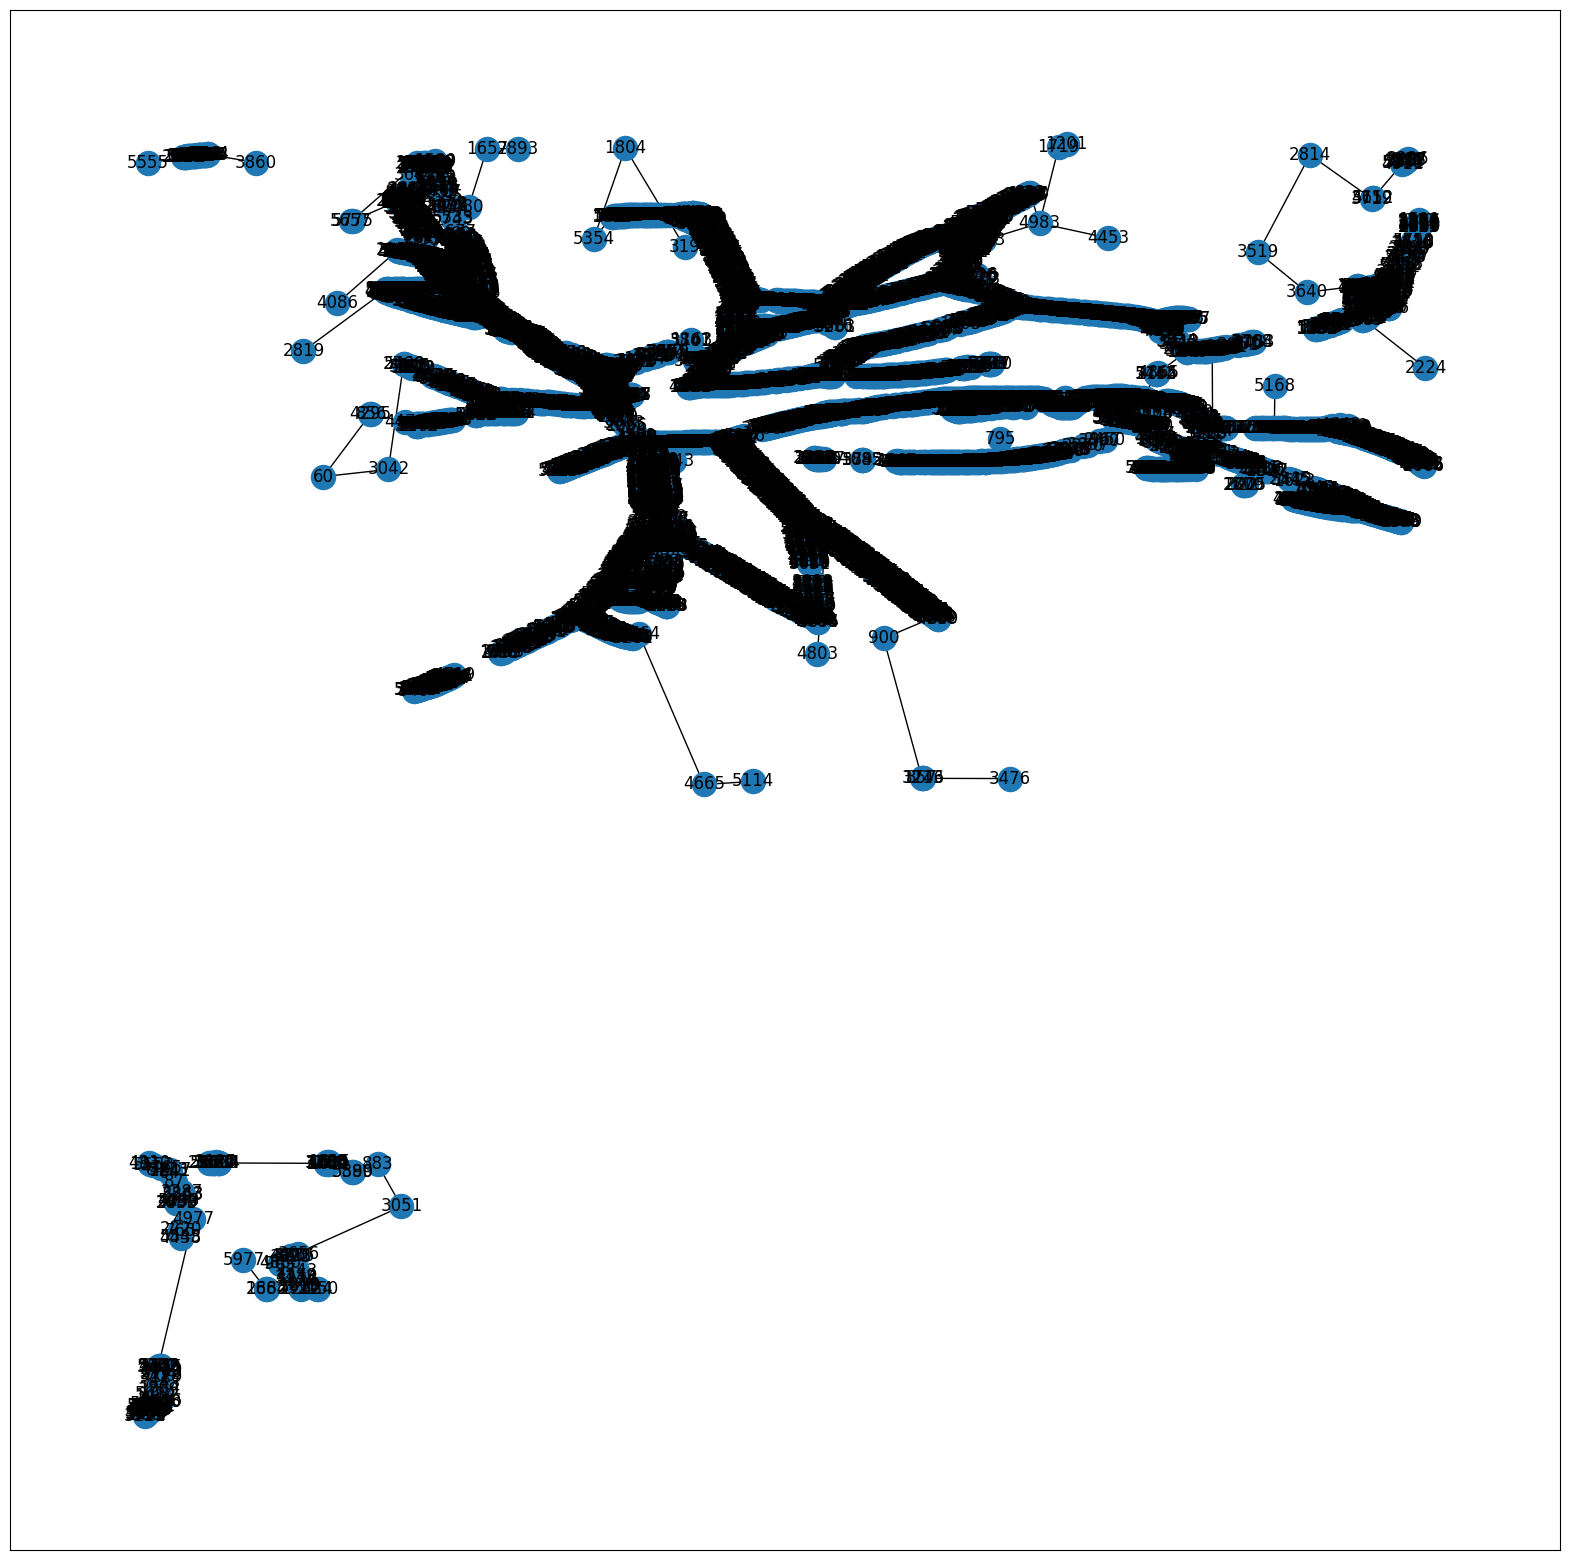

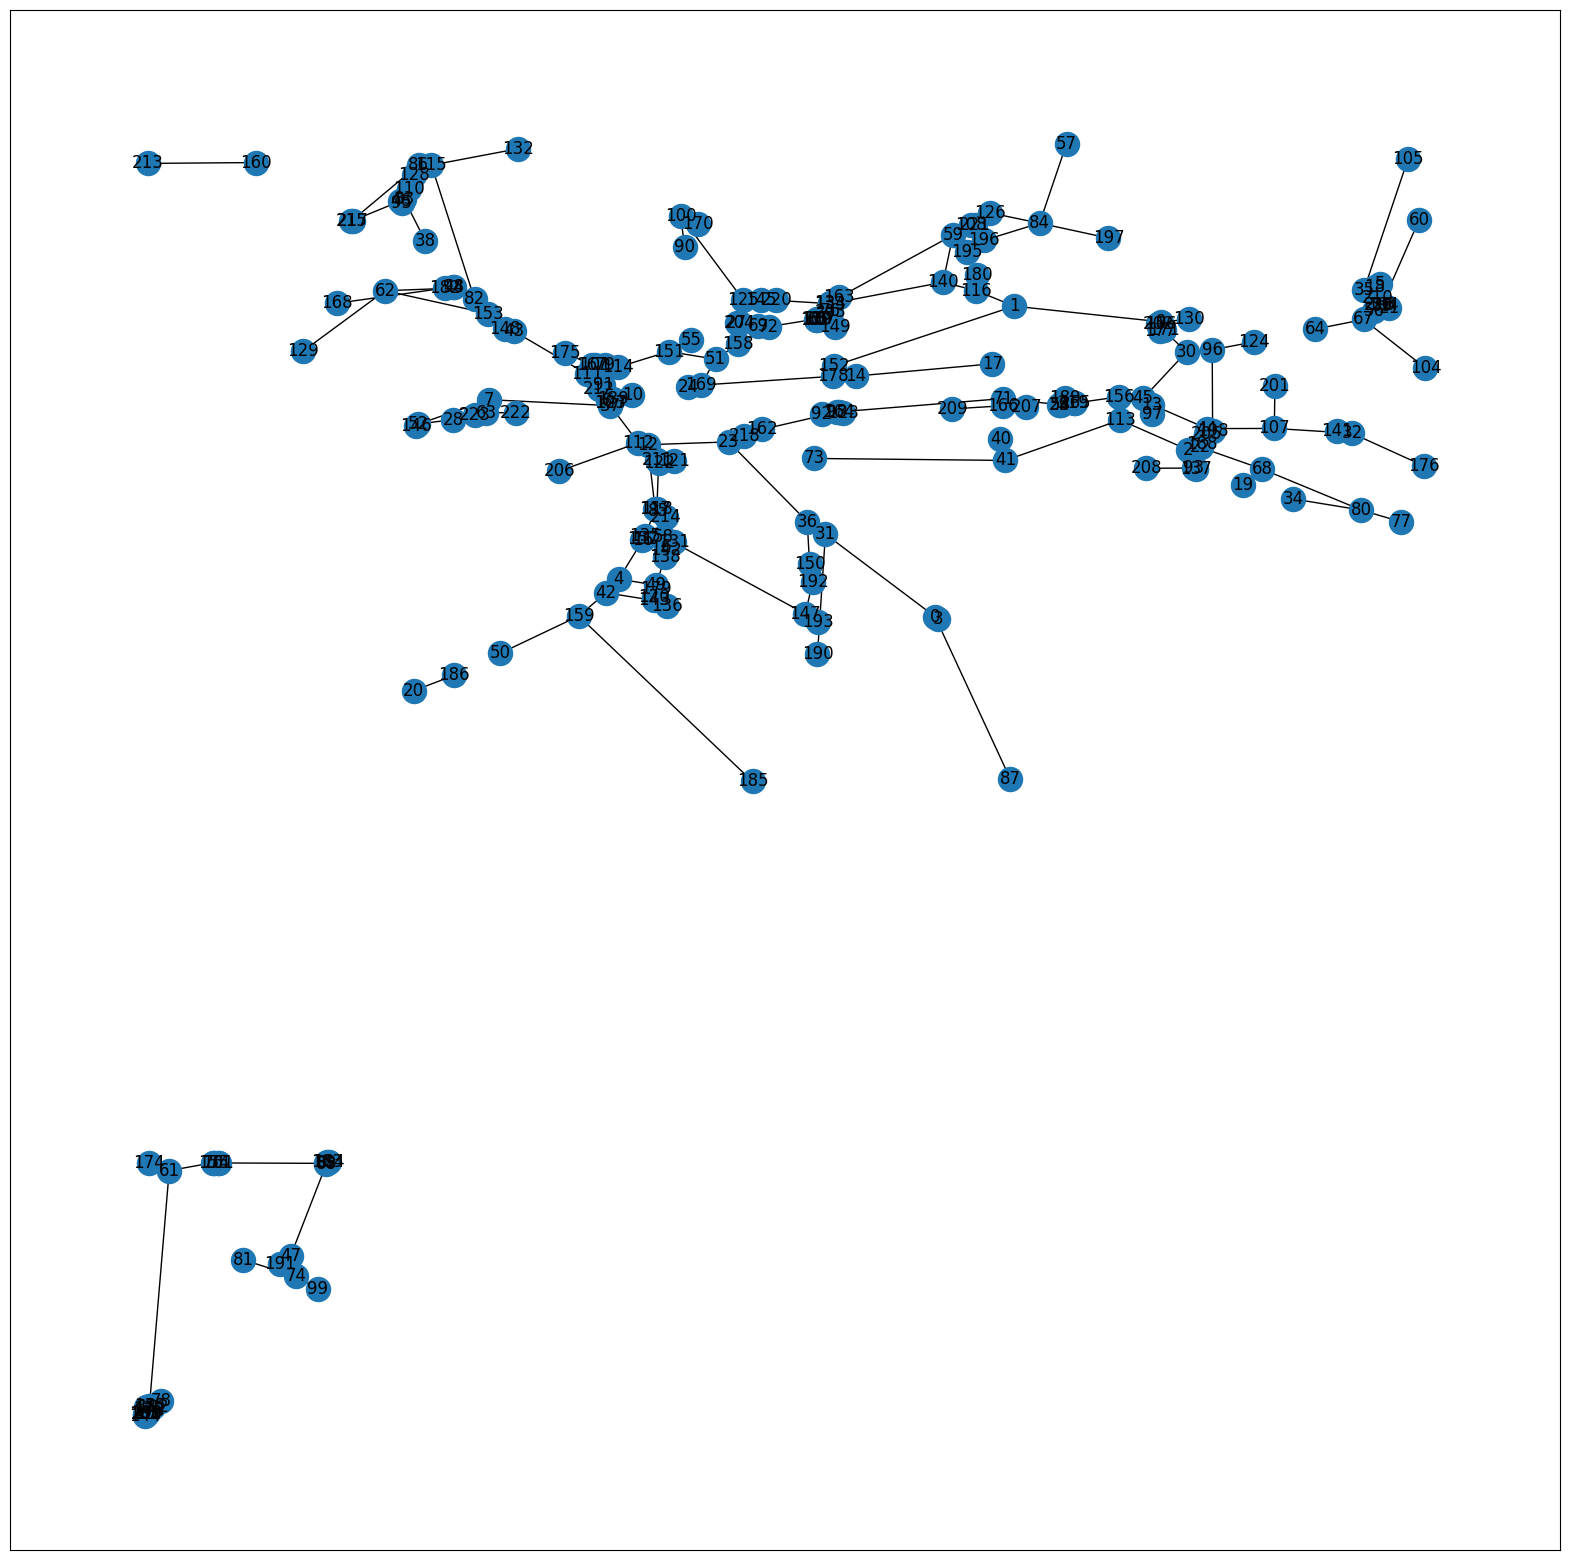

In [4]:
lbc = LBC(point_cloud=pointCloud)
skeleton = lbc.extract_skeleton()
topology = lbc.extract_topology()
lbc.visualize()
lbc.show_graph(lbc.skeleton_graph)
lbc.show_graph(lbc.topology_graph)
# lbc.save('./lbc_2d_web_scan')
# lbc.animate(init_rot=np.asarray([[1, 0, 0], [0, 0, 1], [0, 1, 0]]),
#             steps=300,
#             output='./lbc_2d_web_scan')

In [7]:
lbc.animate(
            steps=300,
            output='./lbc_2d_web_scan')